# Identify Fraud from Enron Email 

## Project Overview

Enron scandal is one of the most famous scandals in the world. Because of the fraud, Enron went bankrupt in 2002. I heard and learnt a lot about it since day one in business school. During that time, all I learnt was about how did they cheat on their financial statement, but why Arthur Andersen, the auditor, did not find out. 

I was very excited when I knew there are tens of thousands of emails and detailed financial data for top executives, which I have never heard or thought about before. By playing around with these datasets, I can become a detective, my dreamy job when I was a kid after watching a lot Case Closed, to identify person of interest. 

In this project, I will apply what I my machine learning knowledge in this project to build up algorithms to find out who were involved in the scandle, meaning they were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity.

The main code will be stored in poi_id.py file.

## Dataset Explanation& Problems Statement

The dataset I am going to use includes the financial and email information of people related to the scandle. The information will be read to a dictionary. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

* financial features (all units are in US dollars)
    * 'salary'
    * 'deferral_payments'
    * 'total_payments'
    * 'loan_advances'
    * 'bonus'
    * 'restricted_stock_deferred'
    * 'deferred_income'
    * 'total_stock_value'
    * 'expenses'
    * 'exercised_stock_options'
    * 'other'
    * 'long_term_incentive'
    * 'restricted_stock'
    * 'director_fees'


* email features (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)
    * 'to_messages'
    * 'email_address'
    * 'from_poi_to_this_person'
    * 'from_messages'
    * 'from_this_person_to_poi'
    * 'shared_receipt_with_poi'


* POI label (boolean, represented as integer)
    * ‘poi' 
    
    
The question to answer and the goal of this project is to find out what features are related to the person of interest. When there are information without poi labels, the machine learning algorithm will be able to figure out whether this person is person of interest or not.

## Setup

In [1]:
cd /Users/guanrongfu/GitHub/Udacity-DAND/Machine-Learning/supporting-file/final_project

/Users/guanrongfu/GitHub/Udacity-DAND/Machine-Learning/supporting-file/final_project


In [2]:
import sys
sys.path.append("../tools/")
import pickle
from collections import defaultdict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from feature_format import featureFormat, targetFeatureSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from tester import test_classifier

%matplotlib inline

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Exploration

I will explore some key characteristics of this dataset before digging into further analysis.

In [3]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

Total number of data points

In [4]:
len(data_dict)

146

Number of poi vs. Number of non-poi

In [5]:
count_poi = 0
count_non_poi = 0
    
for k, v in data_dict.items():
    if v['poi']:
        count_poi += 1
    else:
        count_non_poi +=1

print "Number of poi: ", count_poi
print "Number of non-poi:", count_non_poi

Number of poi:  18
Number of non-poi: 128


Number of features

In [6]:
for _, v in data_dict.items():
    print len(v)
    break

21


Are there any missing values? I will count the missing values within each field.

In [7]:
count_missing = {}
for _, value in data_dict.items():
    for k, v in value.items(): 
        if v == 'NaN':
            try:
                count_missing[k] += 1
            except:
                count_missing[k] = 1

count_missing

{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 35,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 60,
 'from_poi_to_this_person': 60,
 'from_this_person_to_poi': 60,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 60,
 'to_messages': 60,
 'total_payments': 21,
 'total_stock_value': 20}

We can see that there are a lot of missing values, which can be a problem in future analysis.

## Remove Outliers

The dataset we have may not be clean. There might be some outliers hidden inside that can affect our analysis. Therefore, it is essential to discover those outliers and remove them before conducting further analysis. The features I will start to explore are 'salary' and 'poi'.

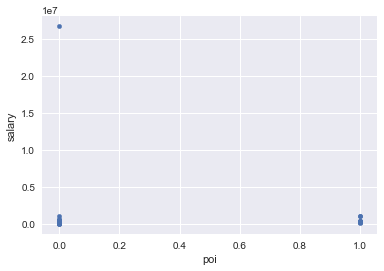

In [8]:
enron_dataframe = pd.DataFrame(data_dict.values())
employees = pd.Series(data_dict.keys())
enron_dataframe.set_index(employees, inplace=True)
enron_dataframe = enron_dataframe.apply(lambda x:
                                        pd.to_numeric(x, errors='coerce'))

poi = pd.Series([0, 1], index=[False, True])
enron_dataframe['poi'] = enron_dataframe.poi.map(poi)

enron_dataframe.plot.scatter(x='poi', y='salary')

There is one point in the dataset that is significantly different from others. It is a good idea to read through the names to find out which data point is the outliers.

In [9]:
for key in data_dict.keys():
    print key

METTS MARK
BAXTER JOHN C
ELLIOTT STEVEN
CORDES WILLIAM R
HANNON KEVIN P
MORDAUNT KRISTINA M
MEYER ROCKFORD G
MCMAHON JEFFREY
HORTON STANLEY C
PIPER GREGORY F
HUMPHREY GENE E
UMANOFF ADAM S
BLACHMAN JEREMY M
SUNDE MARTIN
GIBBS DANA R
LOWRY CHARLES P
COLWELL WESLEY
MULLER MARK S
JACKSON CHARLENE R
WESTFAHL RICHARD K
WALTERS GARETH W
WALLS JR ROBERT H
KITCHEN LOUISE
CHAN RONNIE
BELFER ROBERT
SHANKMAN JEFFREY A
WODRASKA JOHN
BERGSIEKER RICHARD P
URQUHART JOHN A
BIBI PHILIPPE A
RIEKER PAULA H
WHALEY DAVID A
BECK SALLY W
HAUG DAVID L
ECHOLS JOHN B
MENDELSOHN JOHN
HICKERSON GARY J
CLINE KENNETH W
LEWIS RICHARD
HAYES ROBERT E
MCCARTY DANNY J
KOPPER MICHAEL J
LEFF DANIEL P
LAVORATO JOHN J
BERBERIAN DAVID
DETMERING TIMOTHY J
WAKEHAM JOHN
POWERS WILLIAM
GOLD JOSEPH
BANNANTINE JAMES M
DUNCAN JOHN H
SHAPIRO RICHARD S
SHERRIFF JOHN R
SHELBY REX
LEMAISTRE CHARLES
DEFFNER JOSEPH M
KISHKILL JOSEPH G
WHALLEY LAWRENCE G
MCCONNELL MICHAEL S
PIRO JIM
DELAINEY DAVID W
SULLIVAN-SHAKLOVITZ COLLEEN
WROBEL BRUC

There is a key named "TOTAL", which should be the sum of all the other dataset. It is a good idea to remove it. Another weird name is "THE TRAVEL AGENCY IN THE PARK". It doesn't sound like a real person. I will remove it as well.

In [10]:
data_dict.pop('TOTAL', 0)
data_dict.pop('THE TRAVEL AGENCY IN THE PARK',0)

{'bonus': 'NaN',
 'deferral_payments': 'NaN',
 'deferred_income': 'NaN',
 'director_fees': 'NaN',
 'email_address': 'NaN',
 'exercised_stock_options': 'NaN',
 'expenses': 'NaN',
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 'NaN',
 'long_term_incentive': 'NaN',
 'other': 362096,
 'poi': False,
 'restricted_stock': 'NaN',
 'restricted_stock_deferred': 'NaN',
 'salary': 'NaN',
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 362096,
 'total_stock_value': 'NaN'}

There are still some outliers, but it could because they have their special characteristics that make them stand out. I will draw all the other figures to scan through to make sure no significant outliers.

//anaconda/envs/python2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


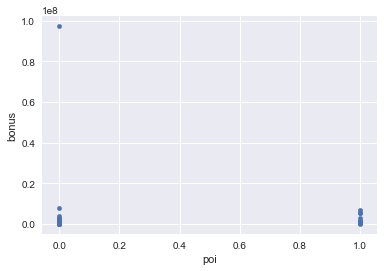

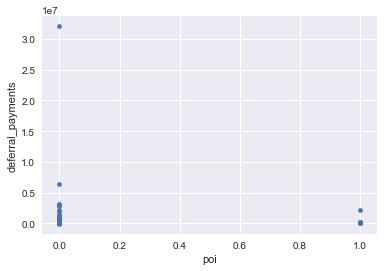

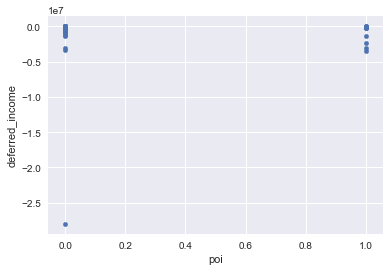

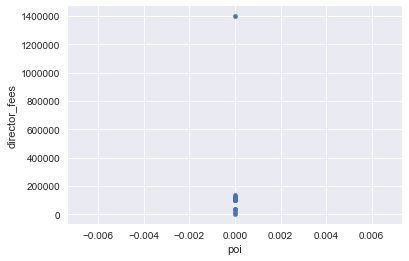

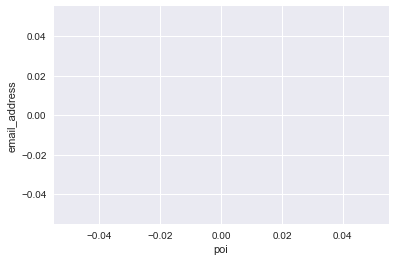

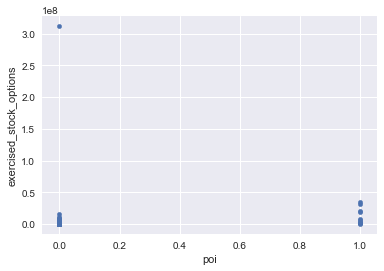

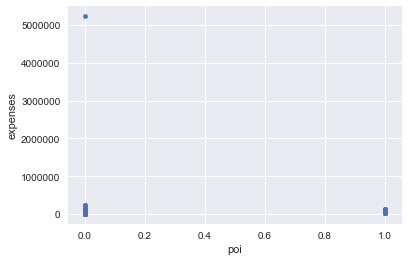

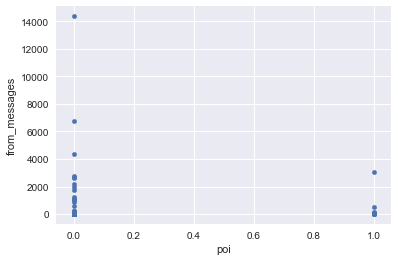

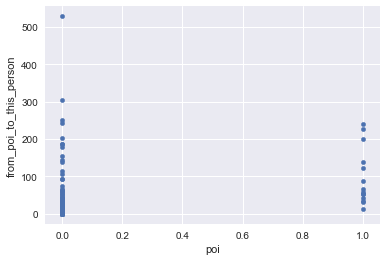

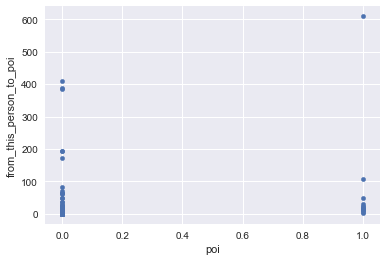

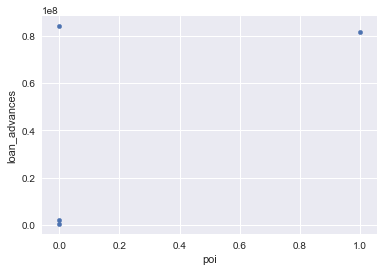

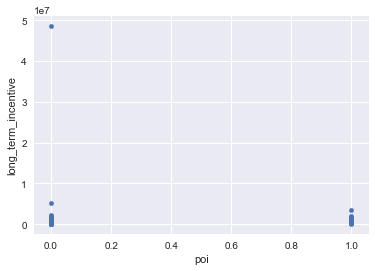

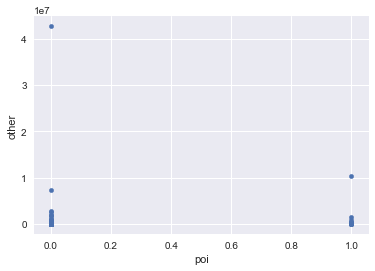

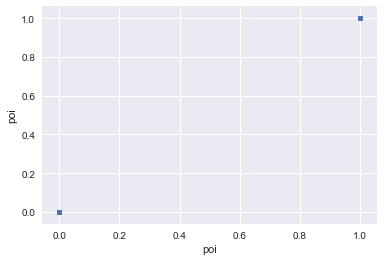

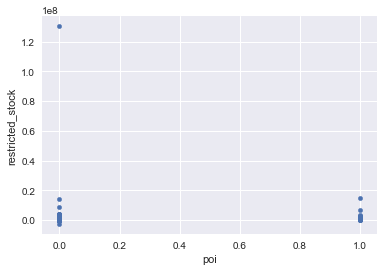

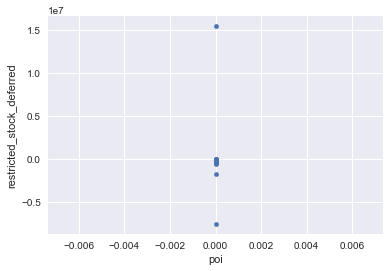

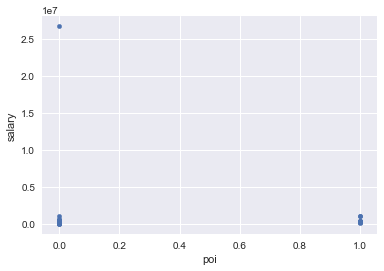

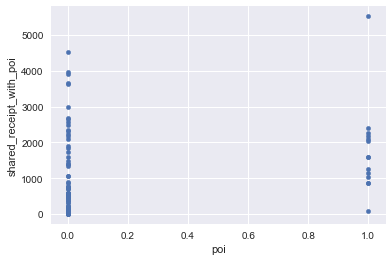

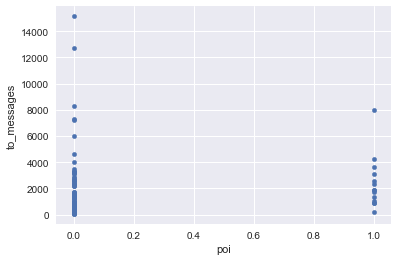

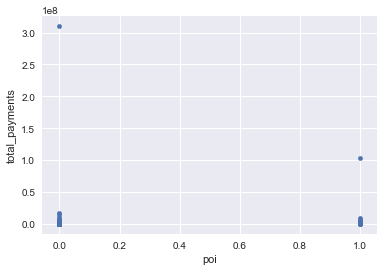

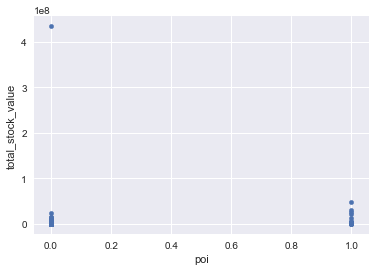

In [11]:
for col in enron_dataframe.columns:
    enron_dataframe.plot.scatter(x='poi', y=col)

There are several points stand out that I want to explore a little bit more. However, since we do not have a lot data in this dataset, I will not remove those potential outliers right now. I might remove them later.

There is one non-poi with significantly high bonus amount.

In [12]:
for k, v in data_dict.items():
    if v['bonus'] != "NaN" and v['bonus'] > 7000000:
        print k, ":", v['bonus']

LAVORATO JOHN J : 8000000


After looking through the original data, this person does have a significantly high bonus comparing with his salary. Normally people with very high bonus are likely to be a poi. It is possible that he is an outlier. 

There is another person with significantly high deferral payments amount.

In [13]:
for k, v in data_dict.items():
    if v['deferral_payments'] != "NaN" and v['deferral_payments'] > 6000000:
        print k, ":", v['deferral_payments']

FREVERT MARK A : 6426990


People with a lot deferred payments are concerned more with the company's long-term development. Hence, they are less likely to be a poi. This data point proves it. He is not an outlier.

An poi has a very high total payment.

In [14]:
for k, v in data_dict.items():
    if v['total_payments'] != "NaN" and v['total_payments'] > 100000000:
        print k, ":", v['total_payments']

LAY KENNETH L : 103559793


He is the CEO of Enron during that time. It is not unusual for him to earn a lot and involve in the scandal. He is not an outlier.

There are some other interesting things I noticed. Two factors, restricted stock deferred and director fee, have too many "NaN", and all people have these information are non-poi. These two features cannot provide much information. Therefore, they will be exclude from further analysis.

## Feature Creation

There are many features available, but not all of them are as informative as others. I will create three more features that I think will be available to the analysis.

* bonus/salary ratio
* from_this_person_to_poi/from_messages ratio
* from_poi_to_this_person/to_messages ratio

At the beginning, I will use all the features and run different algorithms to check the results.

Later, I will applied feature selections to choose the feature that is most effective for the prediction.

I need to first create the original features list. I need to make `poi` the first for further analysis

In [15]:
features_list = []

for _, value in data_dict.items():
    for k, _ in value.items():
        features_list.append(k)
    break

features_list.remove('poi')
features_list.insert(0, 'poi')
features_list

['poi',
 'salary',
 'to_messages',
 'deferral_payments',
 'total_payments',
 'exercised_stock_options',
 'bonus',
 'restricted_stock',
 'shared_receipt_with_poi',
 'restricted_stock_deferred',
 'total_stock_value',
 'expenses',
 'loan_advances',
 'from_messages',
 'other',
 'from_this_person_to_poi',
 'director_fees',
 'deferred_income',
 'long_term_incentive',
 'email_address',
 'from_poi_to_this_person']

Email address will not help with the analysis, and it will cause issues when define labels later. I will remove it.

In [16]:
features_list.remove('email_address')

Now, let's add the three features mentioned above.

In [17]:
# bonus/salary ratio
for employee, features in data_dict.items():
    if features['salary'] != "NaN" and features['bonus'] != 'NaN':
        features['bonus_salary_ratio'] = \
        float(features['salary'])/float(features['bonus'])
    else:
        features['bonus_salary_ratio'] = "NaN"
features_list.append('bonus_salary_ratio')

# from_this_person_to_poi/from_messages ratio
for employee, features in data_dict.items():
    if features['from_this_person_to_poi'] != "NaN" and features['from_messages'] != 'NaN':
        features['from_this_person_to_poi_percentage'] = \
        float(features['from_this_person_to_poi'])/float(features['from_messages'])
    else:
        features['from_this_person_to_poi_percentage'] = "NaN"
features_list.append('from_this_person_to_poi_percentage')

# from_poi_to_this_person/to_messages ratio
for employee, features in data_dict.items():
    if features['from_poi_to_this_person'] != "NaN" and features['to_messages'] != 'NaN':
        features['from_poi_to_this_person_percentage'] = \
        float(features['from_poi_to_this_person'])/float(features['to_messages'])
    else:
        features['from_poi_to_this_person_percentage'] = "NaN"
features_list.append('from_poi_to_this_person_percentage')

Since there are a lot of missing values. I will use the mean to replace NaN.

In [18]:
email_features = ['to_messages',
                  'from_poi_to_this_person',
                  'from_poi_to_this_person_percentage',
                  'from_messages',
                  'from_this_person_to_poi',
                  'from_this_person_to_poi_percentage',
                  'shared_receipt_with_poi']


email_feature_sums = defaultdict(lambda:0)
email_feature_counts = defaultdict(lambda:0)

for employee, features in data_dict.iteritems():
    for feature in email_features:
        if features[feature] != "NaN":
            email_feature_sums[feature] += features[feature]
            email_feature_counts[feature] += 1

email_feature_means = {}
for feature in email_features:
    email_feature_means[feature] = float(email_feature_sums[feature]) / float(email_feature_counts[feature])

for employee, features in data_dict.iteritems():
    for feature in email_features:
        if features[feature] == "NaN":
            features[feature] = email_feature_means[feature]

Last but not the least, for the future analysis, I am going to create another dataset dictionary, so the original dataset won't be influenced.

In [19]:
enron_dataset = data_dict

## Feature Selection & Algorithms

To start to train different algorithms, I will 

* define the training and testing set
* define the cross validation set
* do feature scaling & feature selection
* run different algorithms & tune algorithms
* repeat till reach the expected goal

There are some built functions from feature_format script to help us extract label and feature information.

In [20]:
data = featureFormat(enron_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.2, random_state=42)

Since not all of the features are under the same range. To help with further analysis, I will use standard feature scaling. 

In [21]:
scaler = MinMaxScaler()

In [22]:
features_train_std = scaler.fit_transform(features_train)
features_test_std = scaler.transform(features_test)

In [23]:
select = SelectKBest()

In [24]:
cv = StratifiedShuffleSplit(
    n_splits = 100,
    test_size = 0.3,
    random_state = 6
    )

### Naive Bayes

In [25]:
clf = GaussianNB()
clf.fit(features_train_std, labels_train)
pred = clf.predict(features_test_std)

test_classifier(clf, enron_dataset, features_list)

GaussianNB(priors=None)
	Accuracy: 0.74600	Precision: 0.23177	Recall: 0.39100	F1: 0.29103	F2: 0.34377
	Total predictions: 15000	True positives:  782	False positives: 2592	False negatives: 1218	True negatives: 10408



### Decision Tree

In [26]:
steps = [
    ('feature_selection', select),
    ('tree', DecisionTreeClassifier())
]

pipeline = Pipeline(steps)

parameters = {
    'feature_selection__k': [5, 6, 7, 8, 'all'],
    'tree__min_samples_split': [2, 3, 5],
    'tree__min_samples_leaf': [1, 2, 3]
}

grid = GridSearchCV(pipeline, param_grid=parameters, cv=cv, scoring='f1', error_score=0)
grid.fit(features_train_std, labels_train)
clf=grid.best_estimator_
print "\n", "Best parameters are: ", grid.best_params_, "\n"

features_selected = [features_list[i] 
                     for i in clf.named_steps['feature_selection'].get_support(indices=True)]
features_selected.insert(0, 'poi')

print test_classifier(clf, enron_dataset, features_selected)

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)
//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Best parameters are:  {'tree__min_samples_split': 2, 'feature_selection__k': 'all', 'tree__min_samples_leaf': 1} 



//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Pipeline(steps=[('feature_selection', SelectKBest(k='all', score_func=<function f_classif at 0x1185bd758>)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 1.00000	Precision: 1.00000	Recall: 1.00000	F1: 1.00000	F2: 1.00000
	Total predictions: 15000	True positives: 2000	False positives:    0	False negatives:    0	True negatives: 13000

None


//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 12] are constant.
  UserWarning)


### KNN

In [27]:
estimators = [
    ('feature_selection', select),
    ('knn', KNeighborsClassifier())
]

pipeline = Pipeline(estimators)

parameters = {
    'feature_selection__k': [4, 5, 6, 7, 'all'],
    'knn__n_neighbors': [2, 3, 4, 5],
    'knn__leaf_size': [1, 10, 20, 30],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=cv, error_score=0)
grid.fit(features_train_std, labels_train)

clf = grid.best_estimator_
print "\n", "Best parameters are: ", grid.best_params_, "\n"

features_selected = [features_list[i] 
                     for i in clf.named_steps['feature_selection'].get_support(indices=True)]
features_selected.insert(0, 'poi')

print test_classifier(clf, enron_dataset, features_selected)


Best parameters are:  {'knn__leaf_size': 1, 'feature_selection__k': 'all', 'knn__algorithm': 'auto', 'knn__n_neighbors': 3} 

Pipeline(steps=[('feature_selection', SelectKBest(k='all', score_func=<function f_classif at 0x1185bd758>)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'))])
	Accuracy: 0.87967	Precision: 0.61847	Recall: 0.25450	F1: 0.36061	F2: 0.28845
	Total predictions: 15000	True positives:  509	False positives:  314	False negatives: 1491	True negatives: 12686

None


### Random Forest

In [25]:
steps = [
    ('feature_selection', select),
    ('rf', RandomForestClassifier())
]

pipeline = Pipeline(steps)

parameters = {
    'feature_selection__k': [5, 6, 7, 8, 'all'],
    'rf__n_estimators': [10, 20, 30, 40],
    'rf__min_samples_split': [2, 5, 10],
    'rf__criterion': ['gini', 'entropy'],
    'rf__random_state': [10]    
}

grid = GridSearchCV(pipeline, param_grid=parameters, scoring='f1',
    cv=cv, error_score=0)

grid.fit(features_train_std, labels_train)

clf = grid.best_estimator_
print "\n", "Best parameters are: ", grid.best_params_, "\n"

features_selected = [features_list[i] 
                     for i in clf.named_steps['feature_selection'].get_support(indices=True)]
features_selected.insert(0, 'poi')

print test_classifier(clf, enron_dataset, features_selected)

//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [11] are constant.
  UserWarning)
//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw



Best parameters are:  {'rf__min_samples_split': 5, 'feature_selection__k': 5, 'rf__criterion': 'gini', 'rf__n_estimators': 10, 'rf__random_state': 10} 



//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Pipeline(steps=[('feature_selection', SelectKBest(k=5, score_func=<function f_classif at 0x10f94e758>)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=False))])
	Accuracy: 0.99880	Precision: 0.99157	Recall: 0.99950	F1: 0.99552	F2: 0.99790
	Total predictions: 15000	True positives: 1999	False positives:   17	False negatives:    1	True negatives: 12983

None


### AdaBoost

In [26]:
estimators = [
    ('feature_selection', select),
    ('adb', AdaBoostClassifier())
]

pipeline = Pipeline(estimators)

parameters = {
    'feature_selection__k': [3, 4, 5, 6, 7, 'all'],
    'adb__n_estimators': [10, 50, 100],
    'adb__learning_rate': [0.001, 0.01, 0.1, 1, 2],
    'adb__algorithm': ['SAMME', 'SAMME.R']
}

grid = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=cv, error_score=0)
grid.fit(features_train_std, labels_train)

clf = grid.best_estimator_
print "\n", "Best parameters are: ", grid.best_params_, "\n"

features_selected = [features_list[i] 
                     for i in clf.named_steps['feature_selection'].get_support(indices=True)]
features_selected.insert(0, 'poi')

print test_classifier(clf, enron_dataset, features_selected)


Best parameters are:  {'adb__learning_rate': 0.1, 'adb__n_estimators': 100, 'feature_selection__k': 'all', 'adb__algorithm': 'SAMME.R'} 



//anaconda/envs/python2/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 0 12] are constant.
  UserWarning)


Pipeline(steps=[('feature_selection', SelectKBest(k='all', score_func=<function f_classif at 0x10f94e758>)), ('adb', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=None))])
	Accuracy: 1.00000	Precision: 1.00000	Recall: 1.00000	F1: 1.00000	F2: 1.00000
	Total predictions: 15000	True positives: 2000	False positives:    0	False negatives:    0	True negatives: 13000

None
